# Transfer learning
In the previous exercise we introduced the TinyImageNet-100-A dataset, and combined a handful of pretrained models on this dataset to improve our classification performance.

In this exercise we will explore several ways to adapt one of these same pretrained models to the TinyImageNet-100-B dataset, which does not share any images or object classes with TinyImage-100-A. We will see that we can use a pretrained classfier together with a small amount of training data from TinyImageNet-100-B to achieve reasonable performance on the TinyImageNet-100-B validation set.

In [1]:
# A bit of setup

import numpy as np
import matplotlib.pyplot as plt
from time import time

%matplotlib inline
# This is a bit of magic to make matplotlib figures appear inline in the notebook
# rather than in a new window.
%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

import pandas as pd
import seaborn as sns
sns.set_style('darkgrid')
sns.set_context("notebook", font_scale=1.15, rc={"lines.linewidth": 2.5})

# for auto-reloading extenrnal modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

# Load data and model
You should already have downloaded the TinyImageNet-100-A and TinyImageNet-100-B datasets along with the pretrained models. Run the cell below to load (a subset of) the TinyImageNet-100-B dataset and one of the models that was pretrained on TinyImageNet-100-A.

TinyImageNet-100-B contains 50,000 training images in total (500 per class for all 100 classes) but for this exercise we will use only 5,000 training images (50 per class on average).

In [2]:
# Load the TinyImageNet-100-B dataset

from cs231n.data_utils import load_tiny_imagenet, load_models

tiny_imagenet_b = 'cs231n/datasets/tiny-imagenet-100-B'
        
class_names, X_train, y_train, X_val, y_val, X_test, y_test = load_tiny_imagenet(tiny_imagenet_b)

# Zero-mean the data
mean_img = np.mean(X_train, axis=0)
X_train -= mean_img
X_val -= mean_img
X_test -= mean_img

# We will use a subset of the TinyImageNet-B training data
mask = np.random.choice(X_train.shape[0], size=5000, replace=False)
X_train = X_train[mask]
y_train = y_train[mask]

# Load a pretrained model; it is a five layer convnet.
models_dir = 'cs231n/datasets/tiny-100-A-pretrained'
model = load_models(models_dir)['model1']

loading training data for synset 20 / 100
loading training data for synset 40 / 100
loading training data for synset 60 / 100
loading training data for synset 80 / 100
loading training data for synset 100 / 100


# TinyImageNet-100-B classes
In the previous assignment we printed out a list of all classes in TinyImageNet-100-A. We can do the same on TinyImageNet-100-B; if you compare with the list in the previous exercise you will see that there is no overlap between the classes in TinyImageNet-100-A and TinyImageNet-100-B.

In [3]:
for names in class_names:
    print( ' '.join('"%s"' % name for name in names))

"slug"
"hog" "pig" "grunter" "squealer" "Sus scrofa"
"cougar" "puma" "catamount" "mountain lion" "painter" "panther" "Felis concolor"
"crane"
"vestment"
"dragonfly" "darning needle" "devil's darning needle" "sewing needle" "snake feeder" "snake doctor" "mosquito hawk" "skeeter hawk"
"cash machine" "cash dispenser" "automated teller machine" "automatic teller machine" "automated teller" "automatic teller" "ATM"
"mushroom"
"jinrikisha" "ricksha" "rickshaw"
"water tower"
"chest"
"snorkel"
"sunglasses" "dark glasses" "shades"
"fly"
"limousine" "limo"
"black stork" "Ciconia nigra"
"dugong" "Dugong dugon"
"sports car" "sport car"
"water jug"
"suspension bridge"
"ox"
"ice lolly" "lolly" "lollipop" "popsicle"
"turnstile"
"Christmas stocking"
"broom"
"scorpion"
"wooden spoon"
"picket fence" "paling"
"rugby ball"
"sewing machine"
"steel arch bridge"
"Persian cat"
"refrigerator" "icebox"
"barn"
"apron"
"Yorkshire terrier"
"swimming trunks" "bathing trunks"
"stopwatch" "stop watch"
"lawn mower" "m

# Visualize Examples
Similar to the previous exercise, we can visualize examples from the TinyImageNet-100-B dataset. The images are similar to TinyImageNet-100-A, but the images and classes in the two datasets are disjoint.

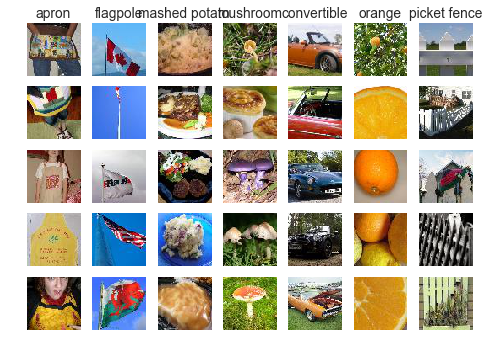

In [4]:
# Visualize some examples of the training data
classes_to_show = 7
examples_per_class = 5

class_idxs = np.random.choice(len(class_names), size=classes_to_show, replace=False)
for i, class_idx in enumerate(class_idxs):
    train_idxs, = np.nonzero(y_train == class_idx)
    train_idxs = np.random.choice(train_idxs, size=examples_per_class, replace=False)
    for j, train_idx in enumerate(train_idxs):
        img = X_train[train_idx] + mean_img
        img = img.transpose(1, 2, 0).astype('uint8')
        plt.subplot(examples_per_class, classes_to_show, 1 + i + classes_to_show * j)
        if j == 0:
            plt.title(class_names[class_idx][0])
        plt.imshow(img)
        plt.gca().axis('off')

plt.show()

# Extract features
ConvNets tend to learn generalizable high-level image features. For the five layer ConvNet architecture, we will use the (rectified) activations of the first fully-connected layer as our high-level image features.

Open the file `cs231n/classifiers/convnet.py` and modify the `five_layer_convnet` function to return features when the `extract_features` flag is `True`. This should be VERY simple.

Once you have done that, fill in the cell below, which should use the pretrained model in the `model` variable to extract features from all images in the training and validation sets.

In [5]:
from cs231n.classifiers.convnet import five_layer_convnet

# These should store extracted features for the training and validation sets
# respectively.
#
# More concretely, X_train_feats should be an array of shape
# (X_train.shape[0], 512) where X_train_feats[i] is the 512-dimensional
# feature vector extracted from X_train[i] using model.
#
# Similarly X_val_feats should have shape (X_val.shape[0], 512) and
# X_val_feats[i] should be the 512-dimensional feature vector extracted from
# X_val[i] using model.
X_train_feats = None
X_val_feats = None

# Use our pre-trained model to extract features on the subsampled training set
# and the validation set.

################################################################################
# TODO: Use the pretrained model to extract features for the training and      #
# validation sets for TinyImageNet-100-B.                                      #
#                                                                              #
# HINT: Similar to computing probabilities in the previous exercise, you       #
# should split the training and validation sets into small batches to avoid    #
# using absurd amounts of memory.                                              #
################################################################################
chunk_size = 1000
list_X_train = [X_train[i:i+chunk_size] for i in range(0, X_train.shape[0], chunk_size)]
list_X_val   = [X_val[i:i+chunk_size] for i in range(0, X_val.shape[0], chunk_size)]

X_train_feats = []
for x in list_X_train:
    X_train_feats.append(five_layer_convnet(x, model, y=None, reg=0.0, dropout=0., 
                                            extract_features=True, compute_dX=False))
X_train_feats = np.concatenate(X_train_feats)

X_val_feats   = []
for x in list_X_val:
    X_val_feats.append(five_layer_convnet(x, model, y=None, reg=0.0, dropout=0., 
                                          extract_features=True, compute_dX=False))
X_val_feats = np.concatenate(X_val_feats)

assert X_val_feats.shape[0] == X_val.shape[0]
assert X_train_feats.shape[0] == X_train.shape[0]
################################################################################
#                            END OF YOUR CODE                                  #
################################################################################   

# kNN with ConvNet features
A simple way to implement transfer learning is to use a k-nearest neighborhood classifier. However instead of computing the distance between images using their pixel values as we did in Assignment 1, we will instead say that the distance between a pair of images is equal to the L2 distance between their feature vectors extracted using our pretrained ConvNet.

Implement this idea in the cell below. You can use the `KNearestNeighbor` class in the file `cs321n/classifiers/k_nearest_neighbor.py`.

In [6]:
from cs231n.classifiers.k_nearest_neighbor import KNearestNeighbor

# Predicted labels for X_val using a k-nearest-neighbor classifier trained on
# the features extracted from X_train. knn_y_val_pred[i] = c indicates that
# the kNN classifier predicts that X_val[i] has label c.
knn_y_val_pred = None

################################################################################
# TODO: Use a k-nearest neighbor classifier to compute knn_y_val_pred.         #
# You may need to experiment with k to get the best performance.               #
################################################################################
knn = KNearestNeighbor() # naming needs to be knn for the below to work.
knn.train(X_train_feats, y_train)
knn_y_val_pred = knn.predict(X_val_feats, k = 5)
################################################################################
#                            END OF YOUR CODE                                  #
################################################################################

print( 'Validation set accuracy: %f' % np.mean(knn_y_val_pred == y_val))

Validation set accuracy: 0.117600


# Visualize neighbors
Recall that the kNN classifier computes the distance between all of its training instances and all of its test instances. We can use this distance matrix to help understand what the ConvNet features care about; specifically, we can select several random images from the validation set and visualize their nearest neighbors in the training set.

You will see that many times the nearest neighbors are quite far away from each other in pixel space; for example two images that show the same object from different perspectives may appear nearby in ConvNet feature space.

Since the following cell selects random validation images, you can run it several times to get different results.

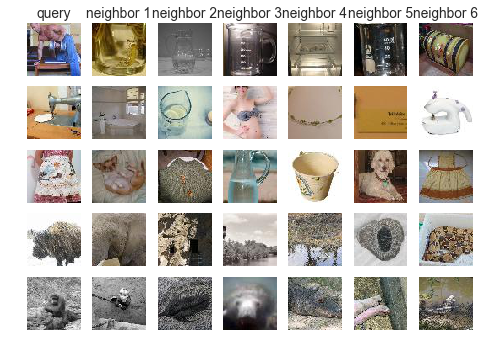

In [7]:
dists = knn.compute_distances_no_loops(X_val_feats)

num_imgs = 5
neighbors_to_show = 6

query_idxs = np.random.randint(X_val_feats.shape[0], size=num_imgs)

next_subplot = 1
first_row = True
for query_idx in query_idxs:
    query_img = X_val[query_idx] + mean_img
    query_img = query_img.transpose(1, 2, 0).astype('uint8')
    plt.subplot(num_imgs, neighbors_to_show + 1, next_subplot)
    plt.imshow(query_img)
    plt.gca().axis('off')
    if first_row:
        plt.title('query')
    next_subplot += 1
    o = np.argsort(dists[query_idx])
    for i in range(neighbors_to_show):            
        img = X_train[o[i]] + mean_img
        img = img.transpose(1, 2, 0).astype('uint8')
        plt.subplot(num_imgs, neighbors_to_show + 1, next_subplot)
        plt.imshow(img)
        plt.gca().axis('off')
        if first_row:
            plt.title('neighbor %d' % (i + 1))
        next_subplot += 1
    first_row = False
    

# Softmax on ConvNet features
Another way to implement transfer learning is to train a linear classifier on top of the features extracted from our pretrained ConvNet.

In the cell below, train a softmax classifier on the features extracted from the training set of TinyImageNet-100-B and use this classifier to predict on the validation set for TinyImageNet-100-B. You can use the `Softmax` class in the file `cs231n/classifiers/linear_classifier.py`.

In [8]:
from cs231n.classifiers.linear_classifier import Softmax

softmax_y_train_pred = None
softmax_y_val_pred = None

################################################################################
# TODO: Train a softmax classifier to predict a TinyImageNet-100-B class from  #
# features extracted from our pretrained ConvNet. Use this classifier to make  #
# predictions for the TinyImageNet-100-B training and validation sets, and     #
# store them in softmax_y_train_pred and softmax_y_val_pred.                   #
#                                                                              #
# You may need to experiment with number of iterations, regularization, and    #
# learning rate in order to get good performance. The softmax classifier       #
# should achieve a higher validation accuracy than the kNN classifier.         #
################################################################################
softmax = Softmax()
softmax.train(X_train_feats.T, y_train, learning_rate=1e-2, reg=1e-3, num_iters=4000, batch_size=600, verbose=True)
y_train_pred = softmax.predict(X_train_feats.T)
y_val_pred = softmax.predict(X_val_feats.T)
################################################################################
#                            END OF YOUR CODE                                  #
################################################################################
train_acc = np.mean(y_train == y_train_pred)
val_acc = np.mean(y_val_pred == y_val)
print( train_acc, val_acc)

iteration 0 / 4000: loss 4.605001
iteration 100 / 4000: loss 4.047964
iteration 200 / 4000: loss 3.702285
iteration 300 / 4000: loss 3.422812
iteration 400 / 4000: loss 3.270287
iteration 500 / 4000: loss 3.064473
iteration 600 / 4000: loss 2.997905
iteration 700 / 4000: loss 2.909176
iteration 800 / 4000: loss 2.769622
iteration 900 / 4000: loss 2.733990
iteration 1000 / 4000: loss 2.571239
iteration 1100 / 4000: loss 2.679701
iteration 1200 / 4000: loss 2.538699
iteration 1300 / 4000: loss 2.437505
iteration 1400 / 4000: loss 2.391762
iteration 1500 / 4000: loss 2.441032
iteration 1600 / 4000: loss 2.368478
iteration 1700 / 4000: loss 2.306805
iteration 1800 / 4000: loss 2.239523
iteration 1900 / 4000: loss 2.140765
iteration 2000 / 4000: loss 2.162593
iteration 2100 / 4000: loss 2.167109
iteration 2200 / 4000: loss 2.122207
iteration 2300 / 4000: loss 2.119353
iteration 2400 / 4000: loss 2.030803
iteration 2500 / 4000: loss 2.069085
iteration 2600 / 4000: loss 2.061830
iteration 270

# Fine-tuning
We can improve our classification results on TinyImageNet-100-B further by fine-tuning our ConvNet. In other words, we will train a new ConvNet with the same architecture as our pretrained model, and use the weights of the pretrained model as an initialization to our new model.

Usually when fine-tuning you would re-initialize the weights of the final affine layer randomly, but in this case we will initialize the weights of the final affine layer using the weights of the trained softmax classifier from above.

In the cell below, use fine-tuning to improve your classification performance on TinyImageNet-100-B. You should be able to outperform the softmax classifier from above using fewer than 5 epochs over the training data.

You will need to adjust the learning rate and regularization to achieve good fine-tuning results.

In [9]:
from cs231n.classifier_trainer import ClassifierTrainer

# Make a copy of the pretrained model
model_copy = {k: v.copy() for k, v in model.items()}

# Initialize the weights of the last affine layer using the trained weights from
# the softmax classifier above
model_copy['W5'] = softmax.W.T.copy().astype(model_copy['W5'].dtype)
model_copy['b5'] = np.zeros_like(model_copy['b5'])

# Fine-tune the model. You will need to adjust the training parameters to get good results.
trainer = ClassifierTrainer()
learning_rate = 5e-5
reg = 0.01
dropout = 0.5
num_epochs = 5
finetuned_model = trainer.train(X_train, y_train, X_val, y_val,
                                model_copy, five_layer_convnet,
                                learning_rate=learning_rate, reg=reg, update='rmsprop',
                                dropout=dropout, num_epochs=num_epochs, verbose=True)[0]

starting iteration  0
Finished epoch 0 / 5: cost 5.739722, train: 0.460000, val 0.200800, lr 5.000000e-05
starting iteration  10
starting iteration  20
starting iteration  30
starting iteration  40
Finished epoch 1 / 5: cost 5.389434, train: 0.624000, val 0.245400, lr 4.750000e-05
starting iteration  50
starting iteration  60
starting iteration  70
starting iteration  80
starting iteration  90
Finished epoch 2 / 5: cost 5.027366, train: 0.690000, val 0.246600, lr 4.512500e-05
starting iteration  100
starting iteration  110
starting iteration  120
starting iteration  130
starting iteration  140
Finished epoch 3 / 5: cost 5.191988, train: 0.699000, val 0.254200, lr 4.286875e-05
starting iteration  150
starting iteration  160
starting iteration  170
starting iteration  180
starting iteration  190
Finished epoch 4 / 5: cost 4.888676, train: 0.717000, val 0.253400, lr 4.072531e-05
starting iteration  200
starting iteration  210
starting iteration  220
starting iteration  230
starting iterat